# Model Deployment Class, replicating

In [123]:
from helper_functions import accuracy_fn, download_data, plot_decision_boundary, plot_loss_curves, plot_predictions, set_seeds
# from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular import engine, data_loaders
from going_modular import predictions
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [124]:
# see torch and torch vision plus
print (torch.__version__)
print (torchvision.__version__)

2.3.0
0.18.0


In [125]:
# !nvcc --version

In [126]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def set_seeds (seed: int=42):
    """_summary_

    Args:
        seed (int, optional): _description_. Defaults to 42.
    """ 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)   

In [127]:
import torch
torch.cuda.is_available()

True

In [128]:
# wet up data paths
# E:\Dropbox\GithubRepo\Udemy\pytorch-deep-learning-main\pytorch-deep-learning-main - Copy\data\pizza_steak_sushi_20_percent
data_20_percent_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
print (f'effnetb2 transforms: {effnetb2_transforms}')
# effnetb2 = torchvision.models.efficientnet_b2(weights="effnetb2_weights")
effnetb2 = torchvision.models.efficientnet_b2(weights="DEFAULT")

for param in effnetb2.parameters():
    param.requires_grad=False


effnetb2 transforms: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [129]:
from torchinfo import summary
# effnetb2
summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [130]:
# get input size of last layer
effnetb2_lastlayer = list(effnetb2.children())[-1]
effnetb2_last_child_layer_inpu_count = list(effnetb2_lastlayer.children())[-1].in_features
effnetb2_last_child_layer_inpu_count

1408

In [131]:
set_seeds()
effnetb2.classifier=nn.Sequential(
    nn.Dropout(p = 0.3, inplace=True),
    nn.Linear(in_features=effnetb2_last_child_layer_inpu_count, out_features=3)

)

In [132]:
# function to create effnetb2
def create_effnetb2(output_feature_count:int, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms= weights.transforms()
    # model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    last_layer = list(model.children())[-1]
    last_child_layer = list(last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features =last_input, 
                  out_features = output_feature_count).to(device))

    model.name = 'effnetb2'
    print (f'[INFO] created new {model.name} model')
    
    return model, transforms




In [133]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [134]:
# data loader
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_loaders.create_dataloaders(train_dir=train_dir, 
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=effnetb2_transforms, 
                                                                                          batch_size=32)

In [135]:
len (train_dataloader_effnetb2), len (test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [136]:
loss_fn = nn.CrossEntropyLoss()
effnetb2_optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

In [137]:
# general trainer

def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device,
           writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    results = {'train_loss':[],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device=device)
        
        print (
            f'Epoch: {epoch + 1} |'
            f'train_loss: {train_loss:.4f} |'
            f'train_acc: {train_acc:.4f} |'
            f'test_loss {test_loss:.4f} |'
            f'test_acc:  {test_acc}:.4f'

        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    if writer:
        writer.add_scalars (main_tag = 'Accuracy',
                            tag_scalar_dict = {'train_acc': train_acc,
                                              'test_acc':test_acc},
                            global_step=epoch)
        writer.add_scalars (main_tag = 'Loss',
                           tag_scalar_dict = {'train_loss': train_loss,
                                              'test_loss' : test_loss},
                            global_step = epoch)
        
        writer.add_graph (model = model,
                          input_to_model = torch.randn(32, 3, 224, 224).to(device))# 3 or 1?
    
    writer.close()

    return results

In [138]:
# train effnetb2
set_seeds()

effnetb2_retults = train (model = effnetb2,
                          train_dataloader=train_dataloader_effnetb2,
                          test_dataloader=test_dataloader_effnetb2,
                          optimizer=effnetb2_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

 10%|█         | 1/10 [00:10<01:36, 10.72s/it]

Epoch: 1 |train_loss: 0.9855 |train_acc: 0.5604 |test_loss 0.7407 |test_acc:  0.934659090909091:.4f


 20%|██        | 2/10 [00:16<01:00,  7.58s/it]

Epoch: 2 |train_loss: 0.7175 |train_acc: 0.8438 |test_loss 0.5869 |test_acc:  0.940909090909091:.4f


 30%|███       | 3/10 [00:21<00:46,  6.63s/it]

Epoch: 3 |train_loss: 0.5876 |train_acc: 0.8917 |test_loss 0.4909 |test_acc:  0.95:.4f


 40%|████      | 4/10 [00:27<00:37,  6.17s/it]

Epoch: 4 |train_loss: 0.4474 |train_acc: 0.9062 |test_loss 0.4355 |test_acc:  0.940909090909091:.4f


 50%|█████     | 5/10 [00:32<00:29,  5.85s/it]

Epoch: 5 |train_loss: 0.4290 |train_acc: 0.9104 |test_loss 0.3915 |test_acc:  0.9443181818181818:.4f


 60%|██████    | 6/10 [00:37<00:22,  5.70s/it]

Epoch: 6 |train_loss: 0.4380 |train_acc: 0.8896 |test_loss 0.3512 |test_acc:  0.96875:.4f


 70%|███████   | 7/10 [00:43<00:16,  5.64s/it]

Epoch: 7 |train_loss: 0.4245 |train_acc: 0.8771 |test_loss 0.3268 |test_acc:  0.95625:.4f


 80%|████████  | 8/10 [00:48<00:11,  5.58s/it]

Epoch: 8 |train_loss: 0.3897 |train_acc: 0.8958 |test_loss 0.3457 |test_acc:  0.9289772727272727:.4f


 90%|█████████ | 9/10 [00:54<00:05,  5.58s/it]

Epoch: 9 |train_loss: 0.3749 |train_acc: 0.8812 |test_loss 0.3129 |test_acc:  0.9130681818181818:.4f


100%|██████████| 10/10 [00:59<00:00,  5.98s/it]

Epoch: 10 |train_loss: 0.3757 |train_acc: 0.8604 |test_loss 0.2813 |test_acc:  0.96875:.4f


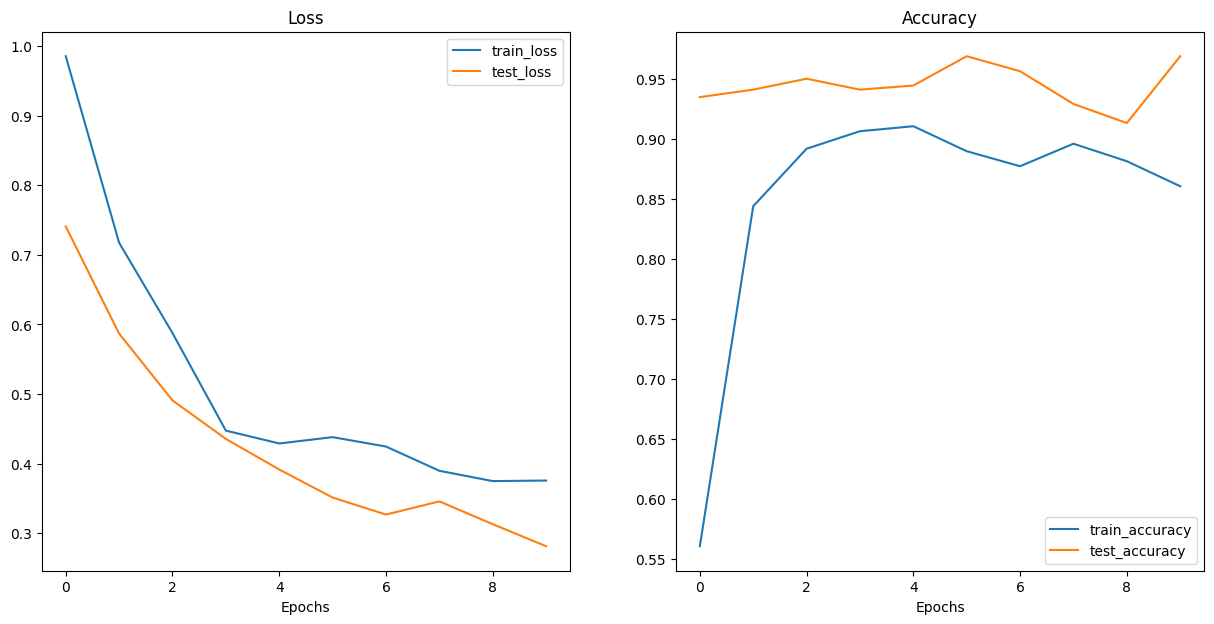

In [139]:
# !nvidia-smi
plot_loss_curves(effnetb2_retults)

### 3.5 Save the EffNetB2 feeature extractor

In [140]:
model_path = f"09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"
save_model (model = effnetb2,
            target_dir="models",
            model_name = model_path)

[INFO] Saving model to: models\09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_10_epochs.pth


### 3.6 inspect size of EFFNetB2

In [141]:
pretrained_effnetb2_model_size = Path("models/", model_path).stat().st_size/(1024 * 1024)

### 3.7 Colling EffNetB2 feature extractor stats

In [142]:
# count number of paramters
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [143]:
effnetb2_stats = {'test_loss':effnetb2_retults['test_loss'][-1],
                  'test_acc':effnetb2_retults['test_acc'][-1],
                  'number_of_paramters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2812606513500214,
 'test_acc': 0.96875,
 'number_of_paramters': 7705221,
 'model_size (MB)': 29.89214515686035}

## 4.0 ViT feature extractor

In [144]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [145]:
# list(list(vit.children())[-1])[-1].in_features

In [146]:
# create vit model
def create_vit_model(num_classes: int = 3, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model= torchvision.models.vit_b_16(weights=weights).to(device)
    transforms=weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    set_seeds(seed=seed)

    last_layer = list (model.children())[-1]
    last_child_layer = list (last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.heads = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features=last_input,
                  out_features=num_classes).to(device))
    
    model.name = 'ViT_B_16'
    print (f'[INFO] created new {model.name} model')

    return model, transforms

In [147]:
vit, vit_transforms = create_vit_model(num_classes=3)

print(summary(model=vit,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

vit_transforms

[INFO] created new ViT_B_16 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)           

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [148]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 4.1 ViT Dataloader

In [149]:
# data loader
train_dataloader_vit, test_dataloader_vit, class_names = data_loaders.create_dataloaders(train_dir=train_dir, 
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms, 
                                                                                          batch_size=32)

### 4.2 Vit training

In [150]:
loss_fn = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

In [151]:
# train vit
set_seeds()

vit_retults = train (model = vit,
                          train_dataloader=train_dataloader_vit,
                          test_dataloader=test_dataloader_vit,
                          optimizer=vit_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

 10%|█         | 1/10 [00:06<01:02,  6.90s/it]

Epoch: 1 |train_loss: 0.7245 |train_acc: 0.7250 |test_loss 0.2896 |test_acc:  0.9289772727272727:.4f


 20%|██        | 2/10 [00:13<00:52,  6.61s/it]

Epoch: 2 |train_loss: 0.2648 |train_acc: 0.9083 |test_loss 0.1720 |test_acc:  0.9602272727272727:.4f


 30%|███       | 3/10 [00:19<00:45,  6.57s/it]

Epoch: 3 |train_loss: 0.1975 |train_acc: 0.9479 |test_loss 0.1281 |test_acc:  0.9693181818181819:.4f


 40%|████      | 4/10 [00:26<00:39,  6.57s/it]

Epoch: 4 |train_loss: 0.1410 |train_acc: 0.9604 |test_loss 0.1085 |test_acc:  0.972159090909091:.4f


 50%|█████     | 5/10 [00:32<00:32,  6.56s/it]

Epoch: 5 |train_loss: 0.1234 |train_acc: 0.9646 |test_loss 0.0965 |test_acc:  0.978409090909091:.4f


 60%|██████    | 6/10 [00:39<00:26,  6.52s/it]

Epoch: 6 |train_loss: 0.1387 |train_acc: 0.9354 |test_loss 0.0846 |test_acc:  0.972159090909091:.4f


 70%|███████   | 7/10 [00:45<00:19,  6.51s/it]

Epoch: 7 |train_loss: 0.1079 |train_acc: 0.9625 |test_loss 0.0831 |test_acc:  0.9875:.4f


 80%|████████  | 8/10 [00:52<00:13,  6.51s/it]

Epoch: 8 |train_loss: 0.1237 |train_acc: 0.9437 |test_loss 0.0761 |test_acc:  0.978409090909091:.4f


 90%|█████████ | 9/10 [00:58<00:06,  6.53s/it]

Epoch: 9 |train_loss: 0.1052 |train_acc: 0.9771 |test_loss 0.0750 |test_acc:  0.978409090909091:.4f


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

Epoch: 10 |train_loss: 0.0786 |train_acc: 0.9854 |test_loss 0.0640 |test_acc:  1.0:.4f



c:\Users\Tiger\anaconda3\envs\Py311UdemyWCUDA1\Lib\site-packages\torch\__init__.py:1559: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


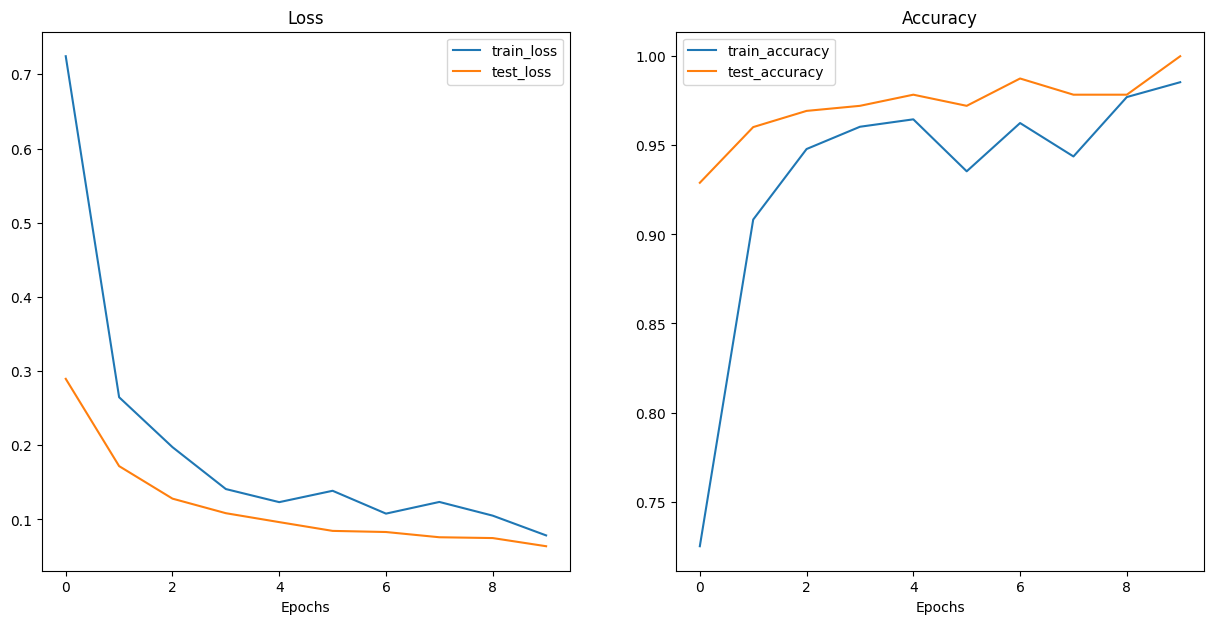

In [152]:
# train effnetb2
plot_loss_curves(vit_retults)

### 4.3 Save the fit feeature extractor

In [153]:
vit_model_path = f"09_pre_trained_vit_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"
save_model (model = vit,
            target_dir="models",
            model_name = vit_model_path)

[INFO] Saving model to: models\09_pre_trained_vit_feature_extractor_pizza_steak_sushi_20_percent_10_epochs.pth


### 4.4 inspect size of vit

In [154]:
pretrained_vit_model_size = Path("models/", vit_model_path).stat().st_size/(1024 * 1024)
pretrained_vit_model_size

327.38194465637207

### 4.6 Collecting vit feature extractor stats

In [155]:
# count number of paramters
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [156]:
vit_stats = {'test_loss':vit_retults['test_loss'][-1],
                  'test_acc':vit_retults['test_acc'][-1],
                  'number_of_paramters': vit_total_params,
                  'model_size (MB)': pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06396642997860909,
 'test_acc': 1.0,
 'number_of_paramters': 85800963,
 'model_size (MB)': 327.38194465637207}

## 5. Making Prediction swith our trained data models


In [157]:
# Get all test data paths
# from tqdm import tqdm
# from pathlib import Path
# test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_labels = [path.parent.stem for path in test_data_paths]
# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    #520cc050-f648-4d4d-b7ae-16850d1a8fbd Get prediction and prediction probability
    from PIL import Image
    
    # 6. timer
    start_time = timer()

    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      # pred_class = class_names[pred_label.cpu()]
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

      # 12. End timerer
      end_time = timer()
      pred_dict["time_for_pred"] = round (end_time - start_time, 4)
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

# test_pred_dicts = pred_and_store(test_paths=test_data_paths,
#                                  model=pretrained_vit_swag,
#                                  transform=vit_transforms_swag,
#                                  class_names=class_names,
#                                  device=device)

# test_pred_dicts[:5]

In [158]:
# test on vit
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]
test_pred_dicts_vit = pred_and_store(test_paths=test_data_paths,
                                 model=vit,
                                 transform=vit_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts_vit[:5]

100%|██████████| 150/150 [00:02<00:00, 51.28it/s]


[{'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9985803365707397,
  'pred_class': 'pizza',
  'time_for_pred': 0.027,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9952054023742676,
  'pred_class': 'pizza',
  'time_for_pred': 0.0278,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9984466433525085,
  'pred_class': 'pizza',
  'time_for_pred': 0.0246,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9858282804489136,
  'pred_class': 'pizza',
  'time_for_pred': 0.0221,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'class_name'

In [159]:
# 
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]
test_pred_dicts_effnetb2 = pred_and_store(test_paths=test_data_paths,
                                 model=effnetb2,
                                 transform=effnetb2_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts_effnetb2[:5]

100%|██████████| 150/150 [00:05<00:00, 27.14it/s]


[{'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.40349331498146057,
  'pred_class': 'sushi',
  'time_for_pred': 0.0389,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.3899497091770172,
  'pred_class': 'sushi',
  'time_for_pred': 0.034,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.36351701617240906,
  'pred_class': 'sushi',
  'time_for_pred': 0.0397,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.36818185448646545,
  'pred_class': 'sushi',
  'time_for_pred': 0.0341,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'clas

In [162]:
effnet2b_test_pred_df = pd. DataFrame(test_pred_dicts_effnetb2)
effnet2b_test_pred_df.head(2)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.403493,sushi,0.0389,False
1,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.389950,sushi,0.0340,False


In [163]:
# check number of correct predictions
effnet2b_test_pred_df.correct.value_counts()

correct
False    117
True      33
Name: count, dtype: int64

In [164]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnet2b_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0364 seconds


In [165]:
effnetb2_stats['time_per_pred_cpu'] =effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2812606513500214,
 'test_acc': 0.96875,
 'number_of_paramters': 7705221,
 'model_size (MB)': 29.89214515686035,
 'time_per_pred_cpu': 0.0364}

###  5.3 get statsfor stats VIT

In [167]:
# create DF
vit_test_pred_df = pd.DataFrame(test_pred_dicts_vit)
vit_test_pred_df.head(2)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.998580,pizza,0.0270,True
1,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.995205,pizza,0.0278,True


In [168]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True    150
Name: count, dtype: int64

In [170]:
# get average
vit_average_time_per_pred = round (vit_test_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred

0.0192

In [171]:
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06396642997860909,
 'test_acc': 1.0,
 'number_of_paramters': 85800963,
 'model_size (MB)': 327.38194465637207,
 'time_per_pred_cpu': 0.0192}

## 6. Comparing models 

In [175]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])
df['model'] = ["EffNetB2", "ViT"]
df['test_acc'] = round (df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_paramters,model_size (MB),time_per_pred_cpu,model
0,0.281261,96.88,7705221,29.892145,0.0364,EffNetB2
1,0.063966,100.00,85800963,327.381945,0.0192,ViT


In [176]:
# compare Vit to EffNetB2
pd.DataFrame(data= (df.set_index('model').loc['ViT']/df.set_index('model').loc['EffNetB2']),
                        columns = ['Fit to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_paramters,model_size (MB),time_per_pred_cpu
Fit to EffNetB2 ratios,0.227428,1.032205,11.135432,10.952106,0.527473


### 6.1 Visulaizeing speed vs performance

<function matplotlib.pyplot.show(close=None, block=None)>

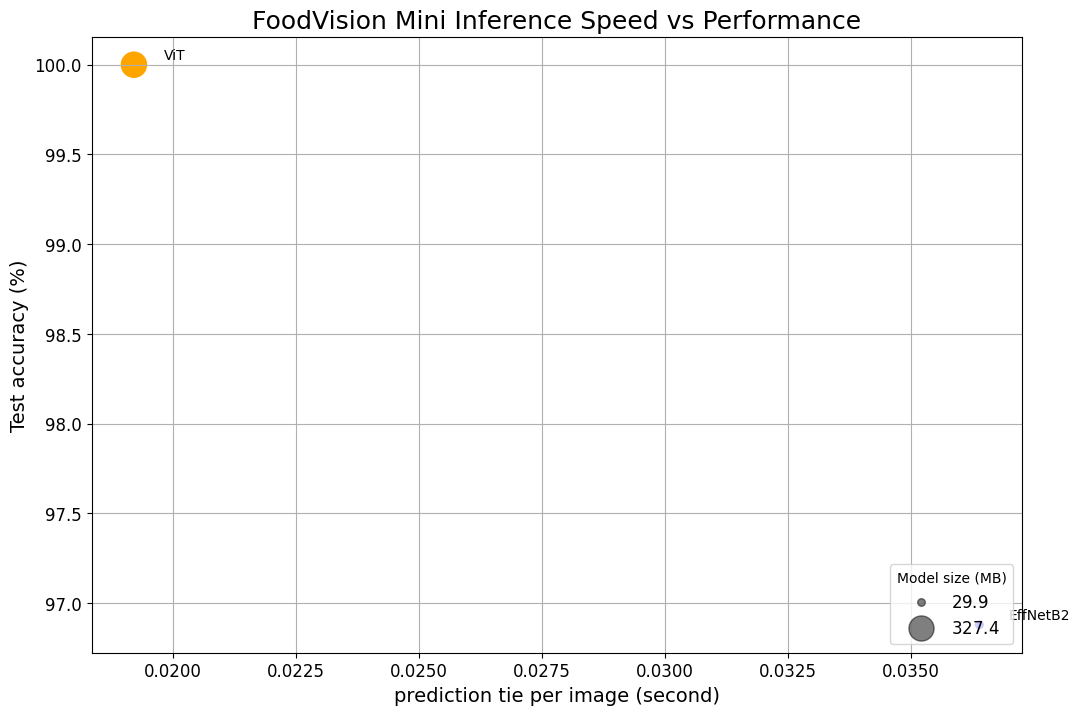

In [188]:
fig, ax = plt.subplots(figsize= (12, 8))
scatter = ax.scatter(data= df,
                     x = 'time_per_pred_cpu',
                     y = 'test_acc',
                     c = ['blue', 'orange'],
                     s = 'model_size (MB)')
ax.set_title ("FoodVision Mini Inference Speed vs Performance", fontsize = 18)
ax.set_xlabel("prediction tie per image (second)", fontsize = 14)
ax.set_ylabel("Test accuracy (%)", fontsize = 14)
ax.tick_params (axis = 'both', labelsize = 12)

ax.grid (True)

# 3. annotate
for index, row in df.iterrows():
    ax.annotate(text = row['model'],
                xy = (row['time_per_pred_cpu']+0.0006, row ['test_acc']+0.03))
    
#  4. Create legedn
handles, labels = scatter.legend_elements (prop='sizes', alpha = 0.5)
models_size_legend = ax.legend(handles,
                               labels,
                               loc = 'lower right',
                               title = "Model size (MB)",
                               fontsize = 12)

plt.show

## 7. Food Vision minto on Gradio

In [ ]:
# 

In [189]:
# import/install gradio
try: 
    import gradio as getattr
except:
    !pip -q install gradio
    import gradio as gr

print (f'Gradio version {gr.__version__}')

Gradio version 5.9.1


In [190]:
# put model to cput
effnetb2.to('cpu')
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [192]:
# recreate workflow
def predict(img) ->Tuple [Dict, float]:

    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim = 1)

    pred_labels_probs = {class_names[i]:float (pred_probs[0][i]) for i in range (len(class_names))}

    pred_time = round (timer() - start_time , 5)

    return pred_labels_probs, pred_time


In [193]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

random_image_path = random.sample (test_data_paths, k = 1)[0]

image = Image.open(random_image_path)

print (f'[INFO] Prediction on image at path: {random_image_path}\n')
pred_dict, pred_time = predict (img = image)
print (f'label and prbob:\n{pred_dict}')
print (f'Prediction Time : {pred_time} seconds')

[INFO] Prediction on image at path: ..\data\pizza_steak_sushi_20_percent\test\sushi\1063878.jpg

label and prbob:
{'pizza': 0.3609239459037781, 'steak': 0.2757018506526947, 'sushi': 0.363374263048172}
Prediction Time : 0.15452 seconds


### 7.3 Creating example list

In [194]:
example_list = [[str(filepath)] for filepath in random.sample (test_data_paths, k = 3)]
example_list

[['..\\data\\pizza_steak_sushi_20_percent\\test\\pizza\\2582289.jpg'],
 ['..\\data\\pizza_steak_sushi_20_percent\\test\\sushi\\472912.jpg'],
 ['..\\data\\pizza_steak_sushi_20_percent\\test\\pizza\\3785667.jpg']]

### 7.4 Build a Gradiao interface

In [199]:
title = "Food vision Mini 🍕🥩🍣"
description = "an EfficentNetB2 feature extract"
article = "Created at Hassan 09"

demo = gr.Interface(fn=predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes = 3, label = "Prdictions"),
                                gr.Number(label = "prediction time")],
                    examples = example_list,
                    title = title,
                    description=description,
                    article=article)

demo.launch(debug=False,
           share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
